# Welcome to Nicholas IBM Data Science Capstone Project Notebook! 
***
### The IBM Data Science Professional Certification is result of a 9 courses program, implemented on Coursera and developed by IBM, that aim to teach and certify new Data Science professionals with excellence, guiding them into the world of Data Science with Python.

 - During my trajectory on the program I have learned many great skills, that will undoubtedly prove to be very useful in my professional path. I will employ those skills here, with dedication, as the next task on my path to be recognized as a promising and competent Data Science Professional.
***
#### This notebook is the place where the Capstone Project of the ninth course was developed by me, and will be pushed to my Github repository for grading and future reference.

In [4]:
import pandas as pd
import numpy as np

In [5]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


# Week 1
***

## Describing the Problem:
In this project two problems were addressed. The initial one opened the possibility to provide another solution based on the same process. Assuming there is a client interested in learning which would be the top five locations in the city to open a food truck business. Investors often depend on intel in order to determine optimal business implementation decisions, such as the tendency a given area have to generate them profit based on a business model. Food trucks have become popular in Brazil over the last few years, having already passed the peak point of the trend. The latter is a crucial point regarding the future of a business model, and those who depend solely on trend tend to fade away after the trend does, so it is imperative not only to investigate whether the food truck business model is still present in the region, but also, if so, in which specific locations; is there a concentration, or a optimum spot? Those questions are the ones that make up this study’s problem. There is already an informal impression that the business model is still present and attractive to many customers after the trend has passed, although the model appears to have changed in some ways, with the observation that the food trucks tend to be more present in areas that already have the appeal for their services, such as events, parties, entertainment venues and so on, often counting with more than a few options, of varied cousines; which could be seen as a collective approach to maximizing profitability and efficiency when it comes to the use of time. Therefore, the final objective is to produce such intel for the client, specifying locations in which the food truck business model tends to succeed the most in the city of Campinas, São Paulo, Brazil. The other problem addressed in this study, is the development of analytical material regarding the neighborhoods in the city and the categories of venues associated with each one, which in turn allows the clustering of neighborhoods based upon their similarities; such material is valuable and can be used for future client’s request or to indirectly help solve other problems.

## Describing the Data and Approach:
Regarding the data that is to be used in this study, the starting point to be described is the neighborhood data about Campinas. A table containing the Neighborhoods names was collected from a previous study, and with some pointers form a colleague, from my universities extension program, that studies geography, a data processing step was able to take place in the QGIS software, that based on the neighborhood names produced their respective latitudes and longitudes coordinates. With the neighborhood dataframe assembled, the next step of the study is to query the Foursquare API in order to retrieve the venues close to each neighborhood, in a radius of 500m, and a limit of 100 venues returned per neighborhood. The query from Foursquare API will then be used to create a dataframe containing each neighborhoods specific venue categories, as well as their density. The data specified will be employed in the development of a K-Means clustering algorithm, doing so based on the venues categories collected and present in each neighborhood. The intent of the study is to identify the cluster to which food trucks belong to, and then locate the top five locations that are both compatible with that business model and also minimally populated by competitors.

# Week 2
***

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [3]:
nb = pd.read_csv('Neighborhoods_Campinas.csv', sep = ';', decimal = ',')
nb.columns = ['Neighborhood', 'Long', 'Lat']
nb.head(10)

,Neighborhood,Long,Lat
0,Arruamento Fain José Feres,-47.084462,-22.821267
1,Arruamento Luiz Vicentin,-47.080811,-22.829629
2,Bairro das Palmeiras,-47.016018,-22.895889
3,Barão Geraldo,-47.079099,-22.845249
4,Bosque das Palmeiras,-47.041516,-22.789775
5,Bosque de Barão Geraldo,-47.102383,-22.827089
6,Campinas Jaguar,-47.047187,-22.875836
7,Chácara Cneo,-47.103938,-22.906759
8,Chácara da Barra,-47.035195,-22.888028
9,Chácara de Recreio Barão,-47.100895,-22.821341


In [3]:
print(nb.shape)
nb.info()

(336, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Neighborhood  336 non-null    object 
 1   Long          336 non-null    float64
 2   Lat           336 non-null    float64
dtypes: float64(2), object(1)
memory usage: 8.0+ KB


In [29]:
address = 'Campinas, SP'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Campinas are {}, {}.'.format(latitude, longitude))

#latitude = -22.90556
#longitude = -47.06083

# create map 
map_cps = folium.Map(location=[latitude, longitude], zoom_start=11.4)

# add markers to map
for lat, lng, neighborhood in zip(nb['Lat'], nb['Long'], nb['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cps)  
    
map_cps

The geograpical coordinates of Campinas are -22.90556, -47.06083.


There are 336 Boroughs from Campinas in the dataframe.

In [5]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [6]:
CLIENT_ID = 'GE1BKI03XMNB0VY0ZGLAG4DKTLRG2LFOJNCU1MU13VX3HJRQ' # your Foursquare ID
CLIENT_SECRET = 'OHUWYN54Y3H55VW4SAVTINN2JODJNNYQD1V550YOFXSB4H12' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GE1BKI03XMNB0VY0ZGLAG4DKTLRG2LFOJNCU1MU13VX3HJRQ
CLIENT_SECRET:OHUWYN54Y3H55VW4SAVTINN2JODJNNYQD1V550YOFXSB4H12


In [7]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

cps_venues = getNearbyVenues(names=nb['Neighborhood'],
                                   latitudes=nb['Lat'],
                                   longitudes=nb['Long'])

In [8]:
#cps_venues.to_csv('cps_venues.csv')

In [9]:
cps_venues = pd.read_csv('cps_venues.csv')
cps_venues.dropna()

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Arruamento Fain José Feres,-22.821267,-47.084462,Praça do Coco,-22.821576,-47.082588,Plaza
1,1,Arruamento Fain José Feres,-22.821267,-47.084462,Feirinha da Praça do Côco,-22.821189,-47.082803,Arts & Crafts Store
2,2,Arruamento Fain José Feres,-22.821267,-47.084462,Quintal De Casa Gourmet,-22.821398,-47.083359,Gastropub
3,3,Arruamento Fain José Feres,-22.821267,-47.084462,Namaste Salad,-22.821280,-47.083065,Restaurant
4,4,Arruamento Fain José Feres,-22.821267,-47.084462,Bronco Burger,-22.823686,-47.083310,Burger Joint
...,...,...,...,...,...,...,...,...
3122,3122,Ville Sainte Helene,-22.896746,-46.989720,Barley Club,-22.894975,-46.991331,Bar
3123,3123,Ville Sainte Helene,-22.896746,-46.989720,Paris 89 Restaurante,-22.893388,-46.991835,Restaurant
3124,3124,Ville Sainte Helene,-22.896746,-46.989720,Brakstube Padaria Alemã,-22.895352,-46.991241,Bakery
3125,3125,Ville Sainte Helene,-22.896746,-46.989720,Pastel Da Feira - Sousas (Kushi),-22.895255,-46.991179,Food Truck


In [10]:
cps_venues['Venue Category'].unique()

array(['Plaza', 'Arts & Crafts Store', 'Gastropub', 'Restaurant',
       'Burger Joint', 'Pizza Place', 'Middle Eastern Restaurant',
       'Food Stand', 'Gym', 'Bar', 'Rock Club', 'Seafood Restaurant',
       'Pharmacy', 'Gym / Fitness Center', 'Café',
       'Vegetarian / Vegan Restaurant', 'Ice Cream Shop',
       'Brazilian Restaurant', 'BBQ Joint', 'Soccer Field', 'Dive Shop',
       'Brewery', 'Music Venue', 'Juice Bar', 'Hot Dog Joint', 'Hotel',
       'Health Food Store', 'Chinese Restaurant', 'Dive Bar',
       'Fruit & Vegetable Store', 'Food Truck', 'Bakery', 'Beer Garden',
       'Health & Beauty Service', 'Dance Studio', 'Laundry Service',
       'Beer Bar', 'Pet Store', 'Snack Place', 'Coffee Shop',
       'Japanese Restaurant', 'Dessert Shop', 'Hostel', 'Supermarket',
       'Travel Agency', 'Convenience Store', 'Clothing Store',
       'Grocery Store', 'Skate Park', 'Acai House', 'Social Club', 'Pool',
       'Tennis Court', 'Volleyball Court', 'Diner', 'Lake',
       '

In [11]:
cps_venues.groupby('Neighborhood').count()

,Unnamed: 0,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
Arruamento Fain José Feres,48,48,48,48,48,48,48
Arruamento Luiz Vicentin,37,37,37,37,37,37,37
Bairro das Palmeiras,11,11,11,11,11,11,11
Barão Geraldo,4,4,4,4,4,4,4
Bosque das Palmeiras,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...
Vila Tofanello,8,8,8,8,8,8,8
Vila Trinta E Um de Marco,6,6,6,6,6,6,6
Vila Ângela Marta,22,22,22,22,22,22,22


In [12]:
print('There are {} uniques categories of venues in Campinas.'.format(len(cps_venues['Venue Category'].unique())))

There are 241 uniques categories of venues in Campinas.


In [13]:
# one hot encoding
cps_onehot = pd.get_dummies(cps_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cps_onehot['Neighborhood'] = cps_venues['Neighborhood'] 

# move neighborhood column to the first column
Nbh = cps_onehot.pop('Neighborhood')
cps_onehot.insert(0, 'Neighborhood', Nbh)

cps_onehot.head()

,Neighborhood,Acai House,Accessories Store,Airport,Airport Lounge,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Candy Store,Chinese Restaurant,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Gym,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Dive Shop,Drugstore,Electronics Store,Empada House,Event Space,Factory,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fraternity House,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Field,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Knitting Store,Lake,Laundry Service,Lawyer,Lingerie Store,Liquor Store,Lottery Retailer,Lounge,Market,Martial Arts Dojo,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Nightclub,Noodle House,Optical Shop,Outdoor Supply Store,Outlet Store,Paintball Field,Paper / Office Supplies Store,Park,Parking,Pastelaria,Pedestrian Plaza,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Professional & Other Places,Pub,Public Art,Racecourse,Racetrack,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Snack Place,Soccer Field,Soccer Stadium,Social Club,Southeastern Brazilian Restaurant,Southern Brazilian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Stationery Store,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Swiss Restaurant,Tea Room,Tennis Court,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Trail,Tram Station,Travel Agency,Tree,Tunnel,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Volleyball Court,Warehouse Store,Water Park,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Arruamento Fain José Feres,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Arruamento Fain José Feres,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [14]:
print("The resulting dataframe has", cps_onehot.shape[0], "observations of venues on different neighborhoods, and", (cps_onehot.shape[1]), "categories of venues.")

The resulting dataframe has 3127 observations of venues on different neighborhoods, and 241 categories of venues.


In [15]:
cps_grouped = cps_onehot.groupby('Neighborhood').mean().reset_index()
cps_grouped

,Neighborhood,Acai House,Accessories Store,Airport,Airport Lounge,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Candy Store,Chinese Restaurant,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Gym,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Dive Shop,Drugstore,Electronics Store,Empada House,Event Space,Factory,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fraternity House,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Field,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Knitting Store,Lake,Laundry Service,Lawyer,Lingerie Store,Liquor Store,Lottery Retailer,Lounge,Market,Martial Arts Dojo,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Nightclub,Noodle House,Optical Shop,Outdoor Supply Store,Outlet Store,Paintball Field,Paper / Office Supplies Store,Park,Parking,Pastelaria,Pedestrian Plaza,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Professional & Other Places,Pub,Public Art,Racecourse,Racetrack,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Snack Place,Soccer Field,Soccer Stadium,Social Club,Southeastern Brazilian Restaurant,Southern Brazilian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Stationery Store,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Swiss Restaurant,Tea Room,Tennis Court,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Trail,Tram Station,Travel Agency,Tree,Tunnel,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Volleyball Court,Warehouse Store,Water Park,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Arruamento Fain José Feres,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.0,0.020833,0.0,0.000000,0.020833,0.0,0.041667,0.0,0.000000,0.020833,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062500,0.0,0.041667,0.0,0.041667,0.0,0.0,0.00,0.0,0.041667,0.0,0.020833,0.0,0.0,0.0,0.000000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.020833,0.0,0.0,0.000000,0.000000,0.020833,0.020833,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.020833,0.020833,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.020833,0.041667,0.0,0.0,0.00,0.020833,0.020833,0.0,0.0,0.0,0.0,0.000000,0.041667,0.041667,0.0,0.0,0.0,0.020833,0.000,0.0,0.000000,0.

In [16]:
num_top_venues = 5

for hood in cps_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = cps_grouped[cps_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arruamento Fain José Feres----
                  venue  freq
0  Brazilian Restaurant  0.06
1           Pizza Place  0.06
2          Burger Joint  0.04
3            Restaurant  0.04
4  Gym / Fitness Center  0.04


----Arruamento Luiz Vicentin----
                  venue  freq
0  Brazilian Restaurant  0.11
1                   Bar  0.11
2           Pizza Place  0.08
3        Ice Cream Shop  0.05
4               Brewery  0.05


----Bairro das Palmeiras----
              venue  freq
0        Restaurant  0.18
1             Diner  0.09
2  Volleyball Court  0.09
3      Tennis Court  0.09
4         BBQ Joint  0.09


----Barão Geraldo----
            venue  freq
0      Restaurant  0.25
1        Bus Stop  0.25
2            Café  0.25
3  Hardware Store  0.25
4      Acai House  0.00


----Bosque das Palmeiras----
          venue  freq
0     Pet Store  0.25
1    Restaurant  0.25
2  Cocktail Bar  0.25
3   Pizza Place  0.25
4    Acai House  0.00


----Bosque de Barão Geraldo----
                  

              venue  freq
0       Bus Station  0.14
1  Department Store  0.14
2            Garden  0.14
3      Burger Joint  0.14
4       Supermarket  0.14


----Jardim Cura D'ars----
            venue  freq
0  Ice Cream Shop  0.14
1     Pizza Place  0.14
2     Snack Place  0.14
3    Churrascaria  0.14
4   Grocery Store  0.14


----Jardim Dom Nery----
              venue  freq
0            Bakery  0.20
1    Ice Cream Shop  0.13
2  Department Store  0.07
3          Pharmacy  0.07
4      Burger Joint  0.07


----Jardim Dom Vieira----
          venue  freq
0         Trail  0.11
1  Outlet Store  0.11
2          Food  0.11
3   Snack Place  0.11
4   Bus Station  0.11


----Jardim Esmeraldina----
                 venue  freq
0         Tram Station   0.2
1        Grocery Store   0.2
2               Buffet   0.2
3        Hot Dog Joint   0.2
4  Arts & Crafts Store   0.2


----Jardim Estoril----
                  venue  freq
0  Gym / Fitness Center  0.25
1                Garden  0.25
2           

          venue  freq
0    Food Truck   0.5
1          Pool   0.5
2    Acai House   0.0
3   Pet Service   0.0
4  Noodle House   0.0


----Jardim Novo São José----
                  venue  freq
0  Brazilian Restaurant  0.12
1                  Park  0.12
2            Baby Store  0.06
3             Drugstore  0.06
4           Coffee Shop  0.06


----Jardim Okita----
                  venue  freq
0           Pizza Place  0.14
1  Gym / Fitness Center  0.14
2                Bakery  0.07
3  Brazilian Restaurant  0.07
4          Outlet Store  0.07


----Jardim Ouro Preto----
           venue  freq
0  Hot Dog Joint   0.5
1    Music Venue   0.5
2     Acai House   0.0
3      Pet Store   0.0
4   Noodle House   0.0


----Jardim Pacaembu----
              venue  freq
0           Brewery  0.17
1            Bakery  0.17
2  Department Store  0.17
3      Burger Joint  0.17
4         Gift Shop  0.17


----Jardim Paranapanema----
                  venue  freq
0                 Plaza  0.33
1      Pedestria

4               Acai House  0.00


----Loteamento Arboreto dos Jequitibas----
               venue  freq
0          Pet Store   1.0
1  Accessories Store   0.0
2          Nightclub   0.0
3       Noodle House   0.0
4       Optical Shop   0.0


----Loteamento Caminhos de São Conrado----
               venue  freq
0  Convenience Store   0.5
1               Park   0.5
2         Acai House   0.0
3          Pet Store   0.0
4       Noodle House   0.0


----Loteamento Center Santa Genebra----
                venue  freq
0          Restaurant  0.29
1                 Gym  0.14
2      Ice Cream Shop  0.07
3                Café  0.07
4  Miscellaneous Shop  0.07


----Loteamento Chácara Prado----
                       venue  freq
0                Pizza Place  0.23
1                     Bakery  0.15
2                   Pharmacy  0.15
3                        Spa  0.08
4  Middle Eastern Restaurant  0.08


----Loteamento Country Ville----
                  venue  freq
0         Grocery Store  0.18
1  

          venue  freq
0     Juice Bar  0.09
1       Brewery  0.06
2  Burger Joint  0.06
3    Food Truck  0.06
4     Pet Store  0.06


----Parque Tropical----
           venue  freq
0         Bakery  0.25
1     Steakhouse  0.12
2  Big Box Store  0.12
3    Supermarket  0.12
4            Bar  0.12


----Parque Universitário de Viracopos----
           venue  freq
0    Supermarket  0.25
1  Shopping Mall  0.25
2       Pharmacy  0.25
3         Bakery  0.25
4     Acai House  0.00


----Parque Valença I----
                  venue  freq
0  Fast Food Restaurant  0.25
1    Athletics & Sports  0.25
2           Bus Station  0.25
3                Bakery  0.25
4            Acai House  0.00


----Parque Via Norte----
                  venue  freq
0  Gym / Fitness Center  0.33
1                   Gym  0.33
2            Food Truck  0.33
3          Noodle House  0.00
4          Optical Shop  0.00


----Parque Viracopos----
           venue  freq
0    Supermarket  0.25
1  Shopping Mall  0.25
2       Phar

4       Pharmacy   0.1


----Vila Industrial----
                venue  freq
0         Snack Place  0.09
1         Supermarket  0.09
2  Italian Restaurant  0.09
3         Music Venue  0.09
4      Ice Cream Shop  0.09


----Vila Ipe----
                  venue  freq
0                Bakery   0.2
1            Food Truck   0.2
2           Snack Place   0.2
3         Shopping Mall   0.2
4  Gym / Fitness Center   0.2


----Vila Itapura----
                  venue  freq
0  Brazilian Restaurant  0.12
1                   Bar  0.11
2                Bakery  0.09
3        Sandwich Place  0.07
4             Bookstore  0.04


----Vila Jequitibas----
            venue  freq
0     Snack Place  0.12
1             Bar  0.08
2      Restaurant  0.08
3  Soccer Stadium  0.08
4    Dance Studio  0.04


----Vila Joaquim Inácio----
                           venue  freq
0                         Bakery  0.09
1                  Hot Dog Joint  0.09
2                            Gym  0.09
3                       P

In [17]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = cps_grouped['Neighborhood']

for ind in np.arange(cps_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cps_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arruamento Fain José Feres,Pizza Place,Brazilian Restaurant,Bar,Brewery,Café,Hot Dog Joint,Hotel,Gym / Fitness Center,Restaurant,Burger Joint
1,Arruamento Luiz Vicentin,Bar,Brazilian Restaurant,Pizza Place,Café,Brewery,Ice Cream Shop,Vegetarian / Vegan Restaurant,Snack Place,Supermarket,Beer Bar
2,Bairro das Palmeiras,Restaurant,Pool,Gym,Brazilian Restaurant,Tennis Court,BBQ Joint,Lake,Social Club,Volleyball Court,Diner
3,Barão Geraldo,Hardware Store,Restaurant,Bus Stop,Café,Zoo Exhibit,Fast Food Restaurant,Food Stand,Food Court,Food & Drink Shop,Food
4,Bosque das Palmeiras,Pizza Place,Restaurant,Pet Store,Cocktail Bar,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop,Zoo Exhibit,Farm
...,...,...,...,...,...,...,...,...,...,...,...
315,Vila Tofanello,Liquor Store,Pizza Place,Bakery,Beer Store,Gym,Electronics Store,Arts & Crafts Store,Indian Restaurant,Food,Flower Shop
316,Vila Trinta E Um de Marco,Shopping Mall,Spa,Motorcycle Shop,Comfort Food Restaurant,Bakery,Field,Food Truck,Food Stand,Food Court,Food & Drink Shop
317,Vila Ângela Marta,Bakery,Brazilian Restaurant,Farmers Market,Burger Joint,Food & Drink Shop,Fruit & Vegetable Store,Big Box Store,Market,Sushi Restaurant,Sandwich Place
318,Village Campinas,Food Truck,Brazilian Restaurant,Zoo Exhibit,Cupcake Shop,Forest,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop


/Users/nicholaslepetit/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/nicholaslepetit/opt/miniconda3/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/Users/nicholaslepetit/opt/miniconda3/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


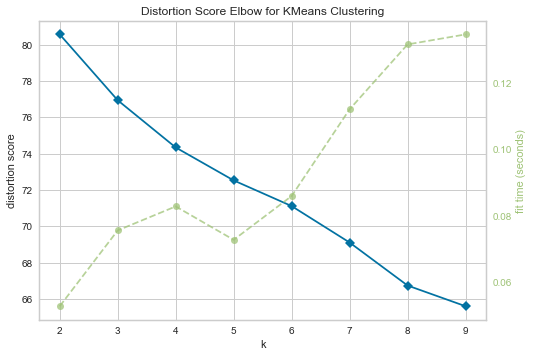

/Users/nicholaslepetit/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x1a20fd6110>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

In [18]:
#!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.datasets.loaders import load_nfl

X = cps_grouped.drop('Neighborhood', axis=1)
kelbow_visualizer(KMeans(random_state=0), X, k=(2,10))#, #metric='calinski_harabasz')

# Note: The warnings go away if you expand the maximum k, but on a trial and error analysis, it was determined
# that higher numbers of K are not optimal for this study. Manually tested K = 3; 4; 8; 12 and 13.

In [19]:
# set number of clusters
kclusters = 8

cps_grouped_clustering = cps_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cps_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([6, 6, 6, 3, 3, 6, 6, 6, 6, 7, 6, 6, 1, 6, 6, 3, 1, 1, 6, 6, 6, 6,
       4, 1, 0, 1, 5, 6, 6, 6, 1, 6, 3, 3, 0, 6, 1, 6, 1, 1, 6, 6, 6, 0,
       1, 0, 0, 1, 3, 6, 6, 1, 6, 6, 1, 6, 6, 6, 6, 1, 6, 1, 6, 6, 1, 6,
       6, 6, 1, 6, 6, 5, 1, 6, 6, 3, 0, 6, 0, 6, 6, 6, 0, 6, 6, 3, 3, 1,
       1, 1, 6, 1, 0, 3, 3, 1, 6, 3, 1, 6, 6, 3, 1, 1, 6, 6, 6, 6, 6, 1,
       6, 6, 3, 0, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 0, 6, 4, 3,
       2, 1, 6, 1, 6, 6, 6, 7, 0, 6, 6, 6, 1, 6, 6, 1, 3, 1, 6, 6, 6, 6,
       1, 1, 2, 4, 6, 6, 6, 3, 1, 1, 6, 6, 6, 6, 3, 3, 6, 1, 6, 6, 6, 4,
       6, 6, 1, 6, 6, 1, 0, 6, 6, 6, 1, 0, 4, 6, 6, 4, 1, 5, 5, 6, 3, 1,
       6, 1, 0, 1, 6, 6, 5, 6, 1, 3, 6, 1, 6, 5, 3, 0, 6, 3, 6, 6, 6, 3,
       6, 1, 6, 6, 1, 1, 1, 0, 1, 6, 6, 6, 6, 3, 0, 6, 6, 1, 6, 7, 3, 6,
       6, 6, 6, 1, 6, 6, 0, 6, 6, 6, 3, 6, 6, 6, 6, 1, 1, 0, 6, 3, 6, 6,
       6, 0, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 0, 6, 3, 6, 6, 0, 6, 6, 6, 3,
       6, 3, 6, 6, 6, 6, 1, 3, 6, 6, 6, 6, 1, 6, 1,

In [20]:
# Adding the clusters identifiers to the previously developed
# dataframe.

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

cps_merged = nb

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
cps_merged = cps_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

cps_merged['Cluster Labels'].fillna(0, inplace= True)
cps_merged['Cluster Labels'] = cps_merged['Cluster Labels'].astype(int)

cps_merged.head() # check the last columns!

,Neighborhood,Long,Lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arruamento Fain José Feres,-47.084462,-22.821267,6,Pizza Place,Brazilian Restaurant,Bar,Brewery,Café,Hot Dog Joint,Hotel,Gym / Fitness Center,Restaurant,Burger Joint
1,Arruamento Luiz Vicentin,-47.080811,-22.829629,6,Bar,Brazilian Restaurant,Pizza Place,Café,Brewery,Ice Cream Shop,Vegetarian / Vegan Restaurant,Snack Place,Supermarket,Beer Bar
2,Bairro das Palmeiras,-47.016018,-22.895889,6,Restaurant,Pool,Gym,Brazilian Restaurant,Tennis Court,BBQ Joint,Lake,Social Club,Volleyball Court,Diner
3,Barão Geraldo,-47.079099,-22.845249,3,Hardware Store,Restaurant,Bus Stop,Café,Zoo Exhibit,Fast Food Restaurant,Food Stand,Food Court,Food & Drink Shop,Food
4,Bosque das Palmeiras,-47.041516,-22.789775,3,Pizza Place,Restaurant,Pet Store,Cocktail Bar,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop,Zoo Exhibit,Farm


In [21]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cps_merged['Lat'], cps_merged['Long'], cps_merged['Neighborhood'], cps_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [22]:
clv = cps_merged[['Cluster Labels', '1st Most Common Venue']]
clv

,Cluster Labels,1st Most Common Venue
0,6,Pizza Place
1,6,Bar
2,6,Restaurant
3,3,Hardware Store
4,3,Pizza Place
...,...,...
331,6,Gym
332,6,Liquor Store
333,1,Shopping Mall
334,0,Food Truck


In [23]:
top5_incluster = clv.groupby(['Cluster Labels','1st Most Common Venue']).size()#.reset_index()
top5_incluster = pd.DataFrame(top5_incluster)
top5_incluster.columns = ['Freq']
top5_incluster.sort_values(['Cluster Labels', 'Freq'], ascending=False, inplace=True)
top5_incluster

Freq
Cluster Labels 1st Most Common Venue      
7              Farm                      2
               Deli / Bodega             1
6              Brazilian Restaurant     17
               Convenience Store         8
               Pizza Place               8
...                                    ...
0              Bakery                    2
               Hot Dog Joint             1
               Hotel                     1
               Pub                       1
               Resort                    1

[126 rows x 1 columns]

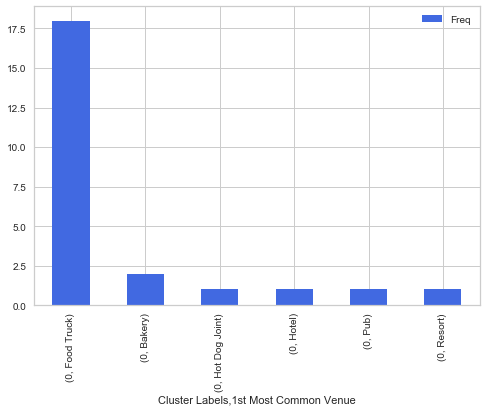

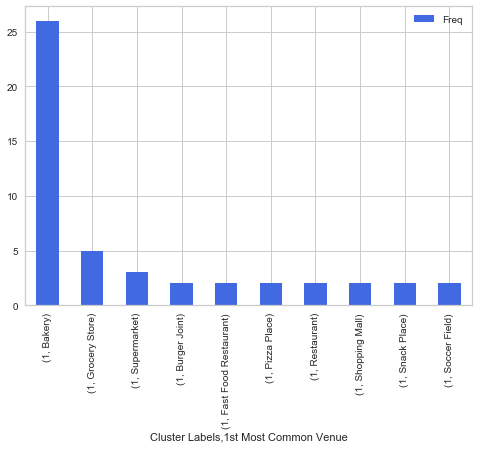

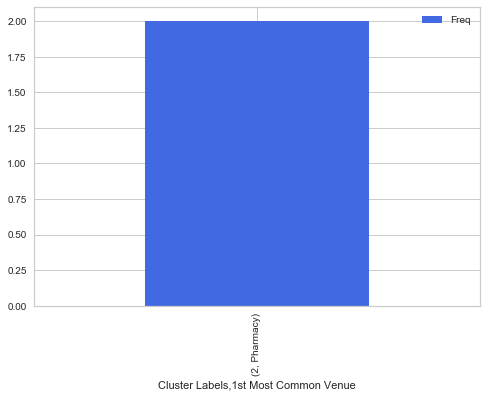

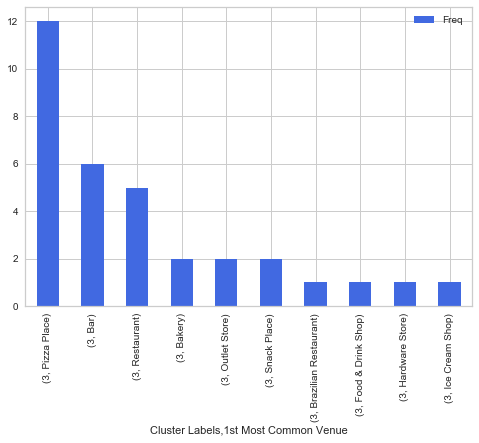

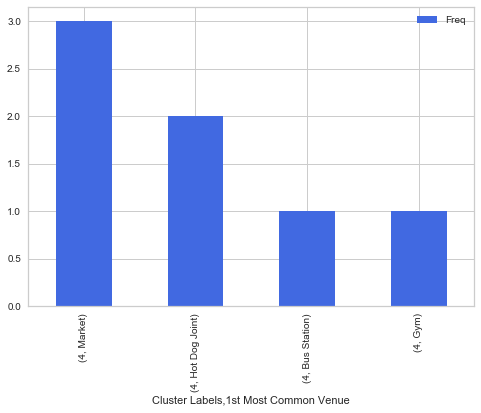

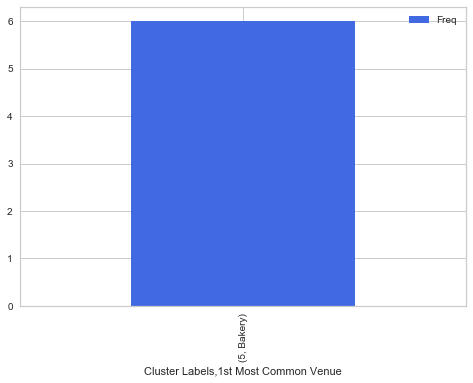

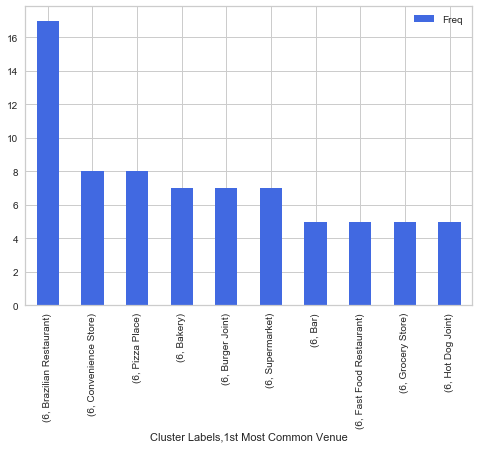

In [24]:
plots=[]

pltcolors = ['red', 'yellow', 'green', 'royalblue', 'blueviolet', 'orange', 'aqua', 'purple', 'slategray', 'olive']

for cluster in np.arange(0,7,1):
    tempdf = top5_incluster[(top5_incluster.index.get_level_values(0) == cluster)].head(10)
    tempdf.plot(kind='bar', color='royalblue')
    plt.show()

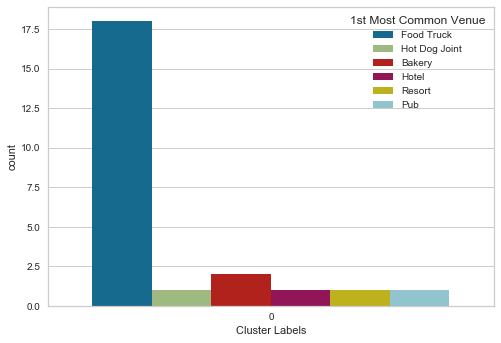

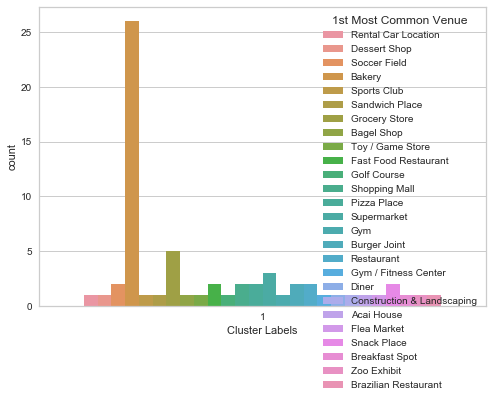

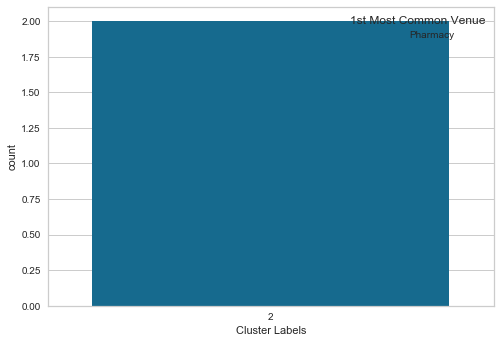

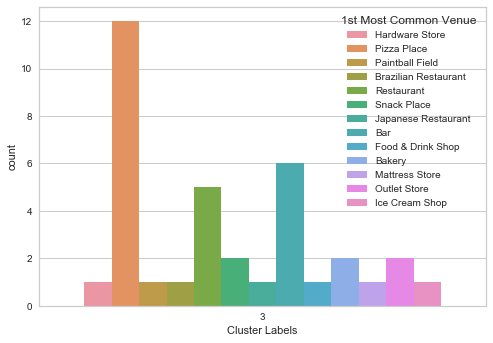

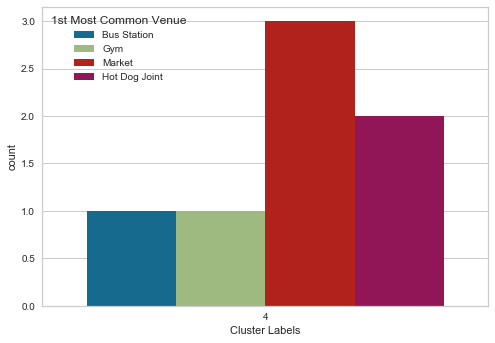

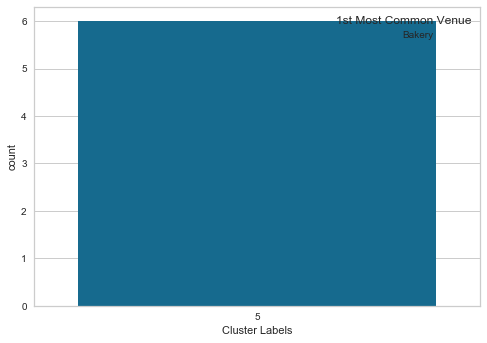

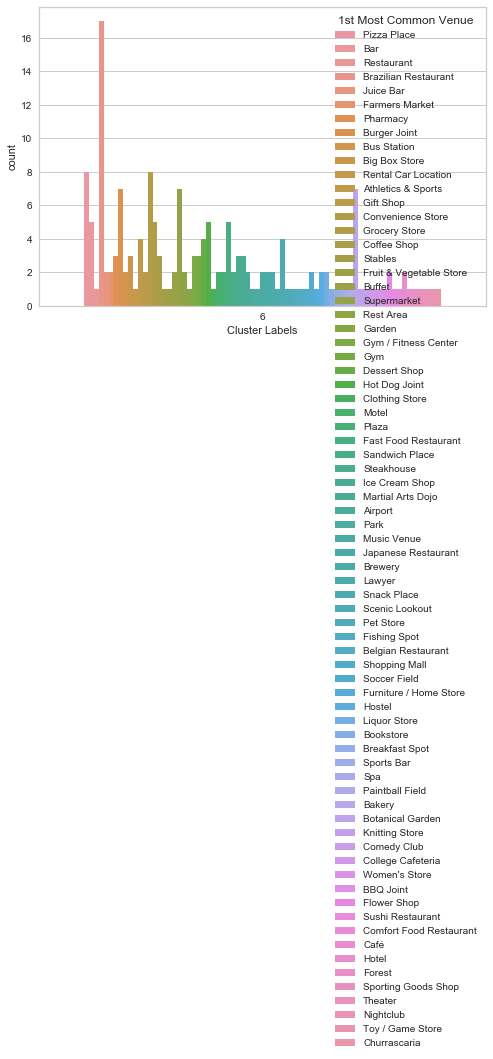

In [25]:
import seaborn as sns

plots=[]

for cluster in np.arange(0,7,1):
    tempdf = clv[clv['Cluster Labels'].eq(cluster)]
    sns.countplot(data=tempdf, x='Cluster Labels', hue='1st Most Common Venue')
    plt.show()

In [27]:

clusterlab = cps_merged[['Neighborhood', 'Cluster Labels']]
#clusterlab

cps_foodtruck = clusterlab.merge(cps_grouped, on='Neighborhood', how='left')
cps_foodtruck

,Neighborhood,Cluster Labels,Acai House,Accessories Store,Airport,Airport Lounge,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Candy Store,Chinese Restaurant,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Gym,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Dive Shop,Drugstore,Electronics Store,Empada House,Event Space,Factory,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fraternity House,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Field,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Knitting Store,Lake,Laundry Service,Lawyer,Lingerie Store,Liquor Store,Lottery Retailer,Lounge,Market,Martial Arts Dojo,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Nightclub,Noodle House,Optical Shop,Outdoor Supply Store,Outlet Store,Paintball Field,Paper / Office Supplies Store,Park,Parking,Pastelaria,Pedestrian Plaza,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Professional & Other Places,Pub,Public Art,Racecourse,Racetrack,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Snack Place,Soccer Field,Soccer Stadium,Social Club,Southeastern Brazilian Restaurant,Southern Brazilian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Stationery Store,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Swiss Restaurant,Tea Room,Tennis Court,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Trail,Tram Station,Travel Agency,Tree,Tunnel,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Volleyball Court,Warehouse Store,Water Park,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Arruamento Fain José Feres,6,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.020833,0.0,0.041667,0.0,0.000000,0.020833,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062500,0.0,0.041667,0.0,0.041667,0.0,0.0,0.00,0.0,0.041667,0.0,0.020833,0.0,0.0,0.0,0.000000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.020833,0.0,0.0,0.000000,0.000000,0.020833,0.020833,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.020833,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.020833,0.041667,0.0,0.0,0.00,0.020833,0.020833,0.0,0.0,0.0,0.0,0.000000,0.041667,0.041667,0.0,0.0,0.0,0.020833,0.000,0.0,0.000000,0.0,0.020833,

In [28]:
cps_foodtruck = cps_foodtruck[cps_foodtruck['Cluster Labels'].eq(0)]
cps_foodtruck = cps_foodtruck[['Neighborhood', 'Food Truck']].sort_values(by='Food Truck', ascending = True)
cps_foodtruck

,Neighborhood,Food Truck
45,Jardim Anchieta,0.142857
46,Jardim Andorinhas,0.166667
192,Nova Aparecida,0.166667
139,Jardim Profilurb,0.166667
151,Jardim Santa Lúcia,0.200000
34,Dic Vi,0.200000
43,Jardim Amazonas,0.200000
210,Parque Brasília,0.200000
87,Jardim Itayu,0.200000
92,Jardim Londres,0.200000


Thank you for reading!